## Import libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Dealing with Data

In [3]:
# Define a custom dataset for pose classification
class PoseDataset(tf.keras.utils.Sequence):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.class_names = os.listdir(data_dir)
        print("class_names:", self.class_names)
        self.file_paths = []
        for i, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            file_list = os.listdir(class_dir)
            self.file_paths += [(os.path.join(class_dir, file), i) for file in file_list]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path, label = self.file_paths[idx]
        sample = np.load(file_path)
        return sample, label

In [4]:
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 5

In [5]:
# Data directory
data_dir = 'data'

# Create a DataLoader for the dataset
dataset = PoseDataset(data_dir)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create TensorFlow data loaders
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data, (tf.float32, tf.int32), (tf.TensorShape([1, 17, 64, 48]), tf.TensorShape([]))
).batch(batch_size).shuffle(buffer_size=len(train_data))

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, (tf.float32, tf.int32), (tf.TensorShape([1, 17, 64, 48]), tf.TensorShape([]))
).batch(batch_size)


class_names: ['action_down', 'action_inside', 'action_new', 'action_outside', 'action_remove_block', 'action_select_block', 'action_switch', 'action_up', 'block_events_ran', 'category_control', 'category_events', 'category_looks', 'category_motion', 'category_sound', 'dummy', 'select_avatar', 'select_backdrop']


In [29]:
# iterator = iter(train_dataset)
# element = next(iterator)
# print(element)

## Model Definition

In [7]:
# Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(1, 17, 64, 48)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(17, activation='softmax')
])

In [12]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model_history = model.fit(train_dataset, epochs=num_epochs)

Epoch 1/5
1014/1014 [==============================] - 59s 30ms/step - loss: 0.0042 - accuracy: 0.9993
Epoch 2/5
1014/1014 [==============================] - 53s 31ms/step - loss: 3.3584e-04 - accuracy: 0.9999
Epoch 3/5
1014/1014 [==============================] - 47s 30ms/step - loss: 2.0086e-06 - accuracy: 1.0000
Epoch 4/5
1014/1014 [==============================] - 46s 34ms/step - loss: 8.4942e-08 - accuracy: 1.0000
Epoch 5/5
1014/1014 [==============================] - 39s 31ms/step - loss: 3.6726e-08 - accuracy: 1.0000


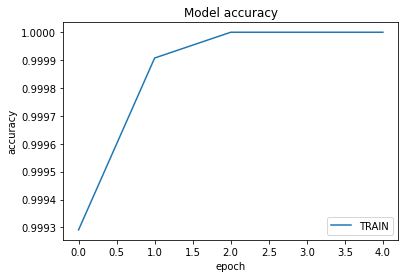

In [26]:
# Visualize the training history
plt.plot(model_history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN'], loc='lower right')
plt.show()

## Model Evaluation on Test set

In [28]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

254/254 [==============================] - 5s 19ms/step - loss: 1.3163e-06 - accuracy: 1.0000
Test Accuracy: 100.00%


## Save the model

In [27]:
# Save the model to disk
model.save('trained_model.h5')